# Aims of this script:

**This is a much simplified notebook to just compare the coarser and finer resolution and get them in the same extent**

Analyse existing water tables to understand potential sources of error and undertake an uncertainty analysis.

To value-add existing water table maps by understanding flow directions, magnitudes, recharge/discharge zones, and geologic structures.

# Importing packages

In [1]:
import contextily
import flopy
from flopy.utils.reference import SpatialReference
import flopy.utils.binaryfile as bf
from flopy import mt3d
import fiona
import geopandas as gpd
from itertools import groupby
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
from osgeo import osr, gdal
import numpy as np
import pyproj
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import Affine
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from requests import Request
import shutil
import shapefile as sf
import subprocess
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
from owslib.wcs import WebCoverageService

%matplotlib notebook

# Check out what versions I am using

To find out GDAL version: use command prompt
GDAL 2.3.3, released 2018/12/14. Got this by typing into conda prompt: `gdalinfo --version`

In [2]:
print('python version: {}' .format(sys.version))
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('pyproj version: {}'.format(pyproj.__version__))

python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.19.2
pandas version: 1.3.4
matplotlib version: 3.1.3
flopy version: 3.3.4
pyproj version: 3.2.1


# Set up the figure formatting

In [3]:
 wt_cmap = "viridis_r"
dem_cmap = "terrain"

# Set up folder structures

In [4]:
os.chdir(r'C:\Users\mar886\WaterTableProject\aewt_project')
print("Current Directory", os.getcwd())

# Make folders for data and figures
if not os.path.exists("input_data"):
    os.makedirs("input_data")
       
if not os.path.exists("figures"):
    os.makedirs("figures")
    
if not os.path.exists("output_data"):
    os.makedirs("output_data")

Current Directory C:\Users\mar886\WaterTableProject\aewt_project


# Projection set ups

In [5]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32755')
gda94 = pyproj.CRS('epsg:4283')

# DEM Data

Start with the DEM data to make the grid, this sets the shape for the other datasets to work with/crop to.

I am importing the ASCII file because I am having trouble working with GTiffs.

DEM is being imported from a folder, it has already been downloaded (i.e. not using web-server).

### First read DEM data as a raster (with projection included)

This is similar to a Python file object, in that it is opened and read. Can check the mode (read or write) using `dem_rstr.mode` and check if its closed using `dem_rstr.closed`.

In [6]:
dem_rstr_nm_asc = os.path.join("input_data", "Elvis_dl_25Oct21",
                               "Hydro_Enforced_1_Second_DEM.asc")

dem_rstr = rio.open(dem_rstr_nm_asc)
print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print(dem_rstr.mode)
print(dem_rstr.closed)

DEM raster crs is: EPSG:4326
DEM raster shape: (4320, 4319)
DEM raster type: <class 'rasterio.io.DatasetReader'>
r
False


### Second, download the raster directly to be an array, with the metadata stored separately.

Instead of `dem_ar = grd.read()[0,:,:]` I could also use `dem_ar = grd.read(1)`, each band is indexed starting at 1 (not 0 like in Python).

The `bounds` bounding box will be used to set up extent throughout the code.

In [7]:
with rio.open(dem_rstr_nm_asc) as grd:
    dem_ar = grd.read()[0,:,:]
    demgrid_meta = grd.profile   
    dembounds = grd.bounds
    demres = grd.res

### Plot the DEM raster and array to show the differences

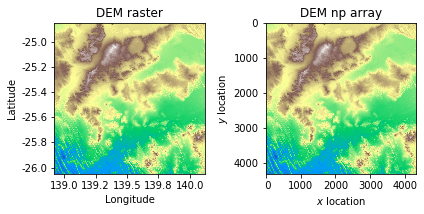

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(dem_rstr, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

ax2.imshow(dem_ar, cmap=dem_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))


ax1.set_title('DEM raster')
ax2.set_title('DEM np array')
plt.tight_layout()


## Set up the extent of the study area using the DEM extent

In [11]:
print("The shape of DEM is: %s" % (dem_ar.shape,))

mask = np.zeros_like(dem_ar)
nrows, ncols = np.shape(mask)

The shape of DEM is: (4320, 4319)


### Make a geodataframe of the bounding box to crop with.

Study extent as a polygon (`studyarea`) or geodataframe (`sa_gdf`).
Geodaframe is what seems to work best for cropping.

In [13]:
studyarea = shapely.geometry.box(dembounds[0], dembounds[1], dembounds[2], dembounds[3]) # minx, miny, maxx, maxy
print(type(studyarea))

print("Area of the study area is: %1.1f square degrees" % studyarea.area)
print("Length of the study area is: %1.1f square degrees" % studyarea.length)

sa_df = pd.DataFrame()

sa_df["geometry"] = [studyarea]

sa_gdf = gpd.GeoDataFrame(sa_df, geometry='geometry',crs=wgs84)
print(type(sa_gdf))

<class 'shapely.geometry.polygon.Polygon'>
Area of the study area is: 1.4 square degrees
Length of the study area is: 4.8 square degrees
<class 'geopandas.geodataframe.GeoDataFrame'>


# Water table elevation raster data

Geoscience Australia also made a raster file of water table elevation (interpolated the contours using TopoToRaster tool in ArcGIS and saved it as ASCII Grid file. This file is not accompanied by a .prj file - i.e. it does not have projection information.

To overcome issues with no projection, my only work-around (for now) was to open the file in ArcGIS and convert it to a Tiff and asign it a projection, I could not figure out how to do this using Python tools.

I am calling this the `wt_rstr_real`, i.e. calling it *real* because it is one that was prepared by a third party, ideally is geologically correct and I can compare it to any interpolation that I do myself.

Note that the cell size is completely different - it is 1000m for this file compared to 30m for the DEM.

## First read WT data as a raster (with projection included)

In [16]:
dem_rstr_nm_asc = os.path.join("input_data", "Elvis_dl_25Oct21",
                               "Hydro_Enforced_1_Second_DEM.asc")

dem_rstr = rio.open(dem_rstr_nm_asc)
print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print(dem_rstr.mode)
print(dem_rstr.closed)

DEM raster crs is: EPSG:4326
DEM raster shape: (4320, 4319)
DEM raster type: <class 'rasterio.io.DatasetReader'>
r
False


In [17]:
wt_rstr_real_file = os.path.join("input_data", "GAB_WT", 
                           "Watertable_Elev", "ASCII_Grid",
                          'wt1.tif')

wt_gab_raster = rio.open(wt_rstr_real_file,
                         driverstr="GTiff")

print("WT raster crs is: %s" % wt_gab_raster.crs)
print("WT raster shape: %s" % (wt_gab_raster.shape,))
print("WT raster type: %s" % (type(wt_gab_raster)))

print(wt_gab_raster.mode)
print(wt_gab_raster.closed)

WT raster crs is: EPSG:4326
WT raster shape: (2306, 2165)
WT raster type: <class 'rasterio.io.DatasetReader'>
r
False


## Second, download the raster directly to be an array, with the metadata stored separately.

In [25]:
with rio.open(wt_rstr_real_file) as wtgrd:
    wt_ar = wtgrd.read()[0,:,:]
    wtgrid_meta = wtgrd.profile   
    wtbounds = wtgrd.bounds
    wtres = wtgrd.res

### Plot the WT raster and array to show the differences

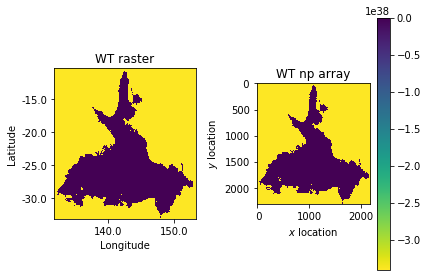

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(wt_gab_raster, ax=ax1, cmap=wt_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

img = ax2.imshow(wt_ar, cmap=wt_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))

plt.colorbar(img)

ax1.set_title('WT raster')
ax2.set_title('WT np array')
plt.tight_layout()

### The DEM has lots of values that are very low - nan values I want to change these to np.nan

In [39]:
wt_ar_filt = np.where(wt_ar < 0, np.nan, wt_ar)


### Re-plot the WT raster and array to show the differences

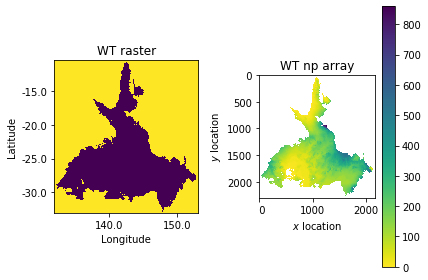

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(wt_gab_raster, ax=ax1, cmap=wt_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

img = ax2.imshow(wt_ar_filt, cmap=wt_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))

plt.colorbar(img)

ax1.set_title('WT raster')
ax2.set_title('WT np array')
plt.tight_layout()

# My four useful datasets:
`dem_rstr`
`dem_ar`
`wt_gab_raster`
`wt_ar_filt`

# My useful metadata

DEM:
`demgrid_meta`    
`dembounds`
`demres`   

WT:
`wtgrid_meta`  
`wtbounds` 
`wtres` 

In [44]:
print(type(dem_rstr))
print(type(dem_ar))
print(type(wt_gab_raster))
print(type(wt_ar_filt))
      
print(dem_rstr.shape)
print(dem_ar.shape)
print(wt_gab_raster.shape)
print(wt_ar_filt.shape)

print(demgrid_meta)
print(wtgrid_meta)

dtype_wt = wtgrid_meta["dtype"]

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(4320, 4319)
(4320, 4319)
(2306, 2165)
(2306, 2165)
{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4319, 'height': 4320, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.000277777777780485, 0.0, 138.92013888913038,
       0.0, -0.000277777777780485, -24.849861111139962), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2165, 'height': 2306, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.009885328723455504, 0.0, 131.7929065313367,
       0.0, -0.009885328723455511, -10.341478515305077), 'tiled': False, 'interleave': 'band'}


## What are the different transforms 

In [45]:
print(demgrid_meta['transform'])
print(wtgrid_meta['transform'])

wt_transform = wtgrid_meta['transform']

| 0.00, 0.00, 138.92|
| 0.00,-0.00,-24.85|
| 0.00, 0.00, 1.00|
| 0.01, 0.00, 131.79|
| 0.00,-0.01,-10.34|
| 0.00, 0.00, 1.00|


In [46]:
print(wt_transform)
print(wt_gab_raster.crs)

| 0.01, 0.00, 131.79|
| 0.00,-0.01,-10.34|
| 0.00, 0.00, 1.00|
EPSG:4326


### What are the different resolutions?

The water table is coarser - I want to convert them both to this size and shape (to this transform)

In [47]:
print(demres)
print(wtres)

print(wt_ar.dtype)

(0.000277777777780485, 0.000277777777780485)
(0.009885328723455504, 0.009885328723455511)
float32


In [65]:
wt_rstr_real_file

'input_data\\GAB_WT\\Watertable_Elev\\ASCII_Grid\\wt1.tif'

# Change tack - using rasterio warp module

See code here: https://www.programcreek.com/python/example/107895/rasterio.warp

'Template' raster bthat has the crs, transform, and dimensions that I want to use: `wt_gab_raster`
'Source' raster that has the data that I want to warp/re-project: `dem_rstr`
'Destination' raster that is new and is where I will (hopefully) save the warped/reprojected raster: `dem_warp_rstr`

In [196]:
from rasterio.warp import reproject, Resampling

src = dem_rstr
tmpl = wt_gab_raster

Array = src.read(1)
OldResolution = src.res
NewResolution = tmpl.res

# setup the transform to change the resolution
XResRatio = OldResolution[0]/NewResolution[0]
YResRatio = OldResolution[1]/NewResolution[1]

NewArray = np.empty(shape=(int(round(Array.shape[0] * XResRatio)), int(round(Array.shape[1] * YResRatio))))

Aff = src.transform # Example code this is src.affine but I'm pretty sure this is depreciated

NewAff = Affine(Aff.a/XResRatio, Aff.b, Aff.c, Aff.d, Aff.e/YResRatio, Aff.f)

# reproject the raster
reproject(Array, NewArray, 
          src_transform=Aff, dst_transform=NewAff, 
          src_crs = src.crs, dst_crs = src.crs, 
          resample=Resampling.bilinear)

In [198]:
print(NewArray.shape)
print(NewArray)

(121, 121)
[[68.22613525 68.33529663 68.56090546 ... 80.46635437 80.23497009
  79.67959595]
 [68.77753448 68.21850586 67.95642853 ... 75.89648438 77.9377594
  80.09583282]
 [67.72668457 68.0218277  67.80093384 ... 75.94393921 77.58955383
  76.77287292]
 ...
 [36.62093353 55.56689835 36.28208542 ... 74.82914734 71.39827728
  75.66077423]
 [42.68743515 38.21448517 33.89664841 ... 77.44497681 69.13474274
  65.07383728]
 [36.6653862  35.67805099 35.94438934 ... 77.08196259 77.81168365
  63.73825836]]


In [199]:
print(tmpl.shape)
print(tmpl.crs)
print(src.shape)
print(src.crs)

print(Array.shape)
print(OldResolution)
print(NewResolution)
print(XResRatio)
print(YResRatio)
print(NewArray.shape)

print(Aff)
print(Aff.a)
print(Aff.b)
print(Aff.c)
print(Aff.d)
print(Aff.e)
print(Aff.f)

print(type(Aff))
print(type(NewAff))

print(NewAff)

(2306, 2165)
EPSG:4326
(4320, 4319)
EPSG:4326
(4320, 4319)
(0.000277777777780485, 0.000277777777780485)
(0.009885328723455504, 0.009885328723455511)
0.02810000411229474
0.02810000411229472
(121, 121)
| 0.00, 0.00, 138.92|
| 0.00,-0.00,-24.85|
| 0.00, 0.00, 1.00|
0.000277777777780485
0.0
138.92013888913038
0.0
-0.000277777777780485
-24.849861111139962
<class 'affine.Affine'>
<class 'affine.Affine'>
| 0.01, 0.00, 138.92|
| 0.00,-0.01,-24.85|
| 0.00, 0.00, 1.00|


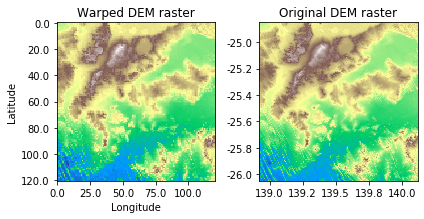

In [200]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(NewArray, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

show(dem_rstr, ax=ax2, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))


ax1.set_title('Warped DEM array')
ax2.set_title('Original DEM raster')
plt.tight_layout()

### Save these results to a geotiff file

In [203]:
NewArray.shape[0]
print(str(NewArray.dtype))

float64


In [204]:
new_dataset = rio.open(
    "dem_warp.tif",
     'w',                                 # Writing the file (making a new raster)
     driver='GTiff',
     height=NewArray.shape[0],
     width=NewArray.shape[1],
     count=1,                             # A count of the dataset bands
     dtype=str(NewArray.dtype),           # Optional
     crs=tmpl.crs,                        # Optional  
     transform=NewAff)                    # Optional
     

new_dataset.write(NewArray, 1)
new_dataset.close()


### Now open the file - before I was writing it, but I need to read it

In [205]:
dem_warp_rstr = rio.open("dem_warp.tif")


In [207]:
print("DEM warp raster crs is: %s" % dem_warp_rstr.crs)
print("DEM warp raster shape: %s" % (dem_warp_rstr.shape,))
print("DEM warp raster type: %s" % (type(dem_warp_rstr)))

print(dem_warp_rstr.mode)
print(dem_warp_rstr.closed)

DEM raster crs is: EPSG:4326
DEM raster shape: (121, 121)
DEM raster type: <class 'rasterio.io.DatasetReader'>
r
False


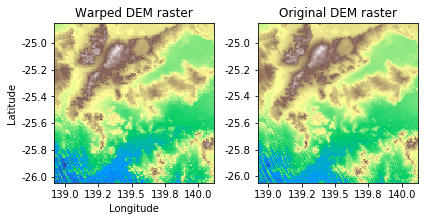

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(dem_warp_rstr, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

show(dem_rstr, ax=ax2, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))


ax1.set_title('Warped DEM raster')
ax2.set_title('Original DEM raster')
plt.tight_layout()

In [212]:
print("Top left original dem: %s" %(dem_rstr.transform * (0,0),))
print("Top left warped dem: %s" %(dem_warp_rstr.transform * (0,0),))

print("Lower right original dem: %s" %(dem_rstr.transform * (dem_rstr.width, dem_rstr.height),))
print("Lower right warped dem: %s" %(dem_warp_rstr.transform * (dem_warp_rstr.width, dem_warp_rstr.height),))


Top left original dem: (138.92013888913038, -24.849861111139962)
Top left warped dem: (138.92013888913038, -24.849861111139962)
Lower right original dem: (140.1198611113643, -26.049861111151657)
Lower right warped dem: (140.1162636646685, -26.04598588667808)


In [210]:
dembounds

BoundingBox(left=138.92013888913038, bottom=-26.049861111151657, right=140.1198611113643, top=-24.849861111139962)

In [139]:
out_file_name = "dem_warp1.tif" 
out_path = os.path.join("output_data", out_file_name)
with rio.open(out_path, 'w', **kwargs) as dst:
    rio.warp.reproject(
                source = dem_rstr.read(1),
                destination = dst,
                src_transform = dem_rstr.transform,
                src_crs = dem_rstr.crs,
                dst_transform = wt_gab_raster.transform,
                dst_crs = wt_gab_raster.transform,
                dst_resolution =  wtres,
                resampling = rio.warp.Resampling.nearest)

ValueError: Invalid destination

In [133]:
with rio.open(dem_rstr_nm_asc) as src:   # This is the path to dem_rstr
    
    transform_warp, width_warp, height_warp = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, 
        dst_width=wt_gab_raster.width, dst_height=wt_gab_raster.height)
    kwargs = src.meta.copy()
    kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
    
    out_file_name = "dem_warp.tif" 
    out_path = os.path.join("output_data", out_file_name)
    with rio.open(out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):   # In case there is more than one band
            rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform_warp,
                    dst_crs=dst_crs,
                    resampling=rasterio.warp.Resampling.nearest)

In [ ]:
with rio.open(dem_rstr_nm_asc) as src:   # This is the path to dem_rstr
    
    transform_warp, width_warp, height_warp = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, 
        dst_width=wt_gab_raster.width, dst_height=wt_gab_raster.height)
    kwargs = src.meta.copy()
    kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
    

In [134]:
print(range(1, src.count + 1))

print(transform_warp)   # The output affine transformation matrix
print(width_warp)       # Output dimensions
print(height_warp)      # Output dimensions

# Compare to the template and source raster transformations, are they different?
print(wt_gab_raster.transform)
print(dem_rstr.transform)

range(1, 2)
| 0.00, 0.00, 138.92|
| 0.00,-0.00,-24.85|
| 0.00, 0.00, 1.00|
2165
2306
| 0.01, 0.00, 131.79|
| 0.00,-0.01,-10.34|
| 0.00, 0.00, 1.00|
| 0.00, 0.00, 138.92|
| 0.00,-0.00,-24.85|
| 0.00, 0.00, 1.00|


### Now open the file

In [135]:
dem_raster_warp = rio.open(out_path, driverstr="GTiff")

In [136]:
print("New DEM raster crs is: %s" % dem_raster_warp.crs)
print("New DEM raster shape: %s" % (dem_raster_warp.shape,))
print("New DEM raster type: %s" % (type(dem_raster_warp)))

print(dem_raster_warp.mode)

print(dem_raster_warp.closed)

New DEM raster crs is: EPSG:4326
New DEM raster shape: (4320, 4319)
New DEM raster type: <class 'rasterio.io.DatasetReader'>
r
False


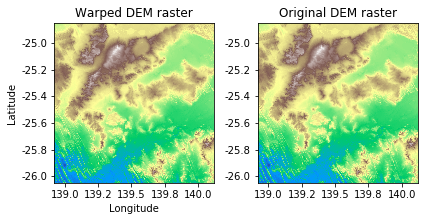

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(dem_raster_warp, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

show(dem_rstr, ax=ax2, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))


ax1.set_title('Warped DEM raster')
ax2.set_title('Original DEM raster')
plt.tight_layout()


# Old below this point

In [86]:
dem_raster_trans = rio.open("dem_translated.tif", driverstr="GTiff")

In [88]:
print("New DEM raster crs is: %s" % dem_raster_trans.crs)
print("New DEM raster shape: %s" % (dem_raster_trans.shape,))
print("New DEM raster type: %s" % (type(dem_raster_trans)))

print(dem_raster_trans.mode)

print(dem_raster_trans.closed)

New DEM raster crs is: EPSG:4326
New DEM raster shape: (2306, 2165)
New DEM raster type: <class 'rasterio.io.DatasetReader'>


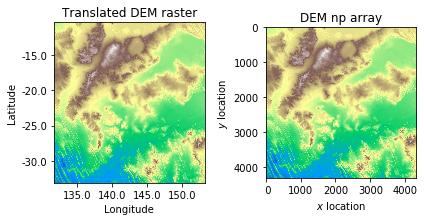

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(dem_raster_trans, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

ax2.imshow(dem_ar, cmap=dem_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))


ax1.set_title('Translated DEM raster')
ax2.set_title('DEM np array')
plt.tight_layout()


### Can I pull in the DEM using this transform?

In [84]:
new_dataset = rasterio.open(
    "dem_translated.tif",
     'w',                                 # Writing the file (making a new raster)
     driver='GTiff',
     height=wt_gab_raster.shape[0],
     width=wt_gab_raster.shape[1],
     count=1,                             # A count of the dataset bands
     dtype=dtype_wt,                      # Optional
     crs=wt_gab_raster.crs,               # Optional  
     transform=wt_transform)              # Optional
     

new_dataset.write(dem_ar, 1)
new_dataset.close()

In [85]:
print("New DEM raster crs is: %s" % new_dataset.crs)
print("New DEM raster shape: %s" % (new_dataset.shape,))
print("New DEM raster type: %s" % (type(new_dataset)))

print(new_dataset.mode)
print(new_dataset.closed)

New DEM raster crs is: EPSG:4326
New DEM raster shape: (2306, 2165)
New DEM raster type: <class 'rasterio.io.DatasetWriter'>
w
True


### Read this raster as an array

In [96]:
dem_ar_trans = dem_raster_trans.read(1)

### Plot them again

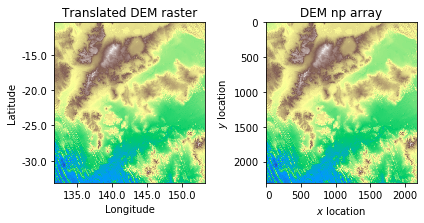

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(dem_raster_trans, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

ax2.imshow(dem_ar_trans, cmap=dem_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))


ax1.set_title('Translated DEM raster')
ax2.set_title('DEM np array')
plt.tight_layout()

In [106]:
print(dem_ar_trans.shape)
print(dem_ar.shape)
print(wt_ar.shape)

print("Top left water table: %s" %(wt_gab_raster.transform * (0,0),))
print("Top left dem: %s" %(dem_raster_trans.transform * (0,0),))

(2306, 2165)
(4320, 4319)
(2306, 2165)
Top left water table: (131.7929065313367, -10.341478515305077)
Top left dem: (131.7929065313367, -10.341478515305077)


## This is potentially dangerous as I think it has just fit the array to the shape and size of the water table - I want it to actually translate the original data.

In [72]:
with rio.open("new_dataset") as wtgrd:
    wt_ar1 = wtgrd.read()[0,:,:]
    wtgrid_meta1 = wtgrd.profile   
    wtbounds1 = wtgrd.bounds
    wtres1 = wtgrd.res

In [ ]:
# these should be the same thing



## Ok that didn't work, can I download as an array instead?

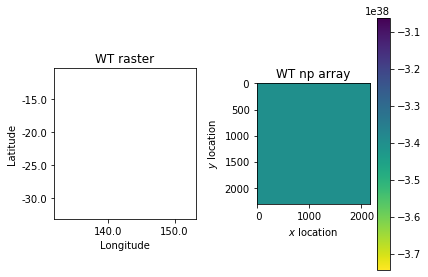

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(wt_gab_raster_reproj, ax=ax1, cmap=wt_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

img = ax2.imshow(wt_ar1, cmap=wt_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))

plt.colorbar(img)

ax1.set_title('WT raster')
ax2.set_title('WT np array')
plt.tight_layout()

## Filter this water table

In [58]:
wt_ar_filt1 = np.where(wt_ar1 < 0, np.nan, wt_ar)

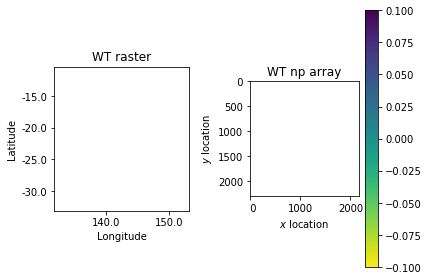

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(wt_gab_raster_reproj, ax=ax1, cmap=wt_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

img = ax2.imshow(wt_ar_filt1, cmap=wt_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
plt.colorbar(img)

ax1.set_title('WT raster')
ax2.set_title('WT np array')
plt.tight_layout()

In [63]:
print(np.nanmin(wt_ar_filt1))

nan


In [64]:
rio.open(wt_rstr_real_file, 
         'w', driver='GTiff', height=wt_gab_raster.shape[0], 
         width=wt_gab_raster.shape[1], count=1, dtype=dtype_wt, 
         crs=wt_gab_raster.crs, transform=wt_transform) as newdemgrd:
    newgrd_meta = newdemgrd.profile
    newwt_ar = newdemgrd.read()[0,:,:]

#new_dataset.close()

SyntaxError: invalid syntax (<ipython-input-64-e2b8314bde60>, line 4)

### Save as a tiff

In [62]:
with rasterio.open("new_dataset", "w", **wtgrid_meta) as dest:
    dest.write(new_dataset)

ValueError: Source shape (2306, 2165) is inconsistent with given indexes 1

### Do it again without the dtype that seems to stuff up the plot

### Plot the new dataset

### Read this tiff back in

In [269]:
wt_gab_raster_real_crop1_nm = os.path.join("output_data", "gab_real_crop_big.tif")

wt_gab_raster_real_crop1 = rio.open(wt_gab_raster_real_crop1_nm, driverstr="GTiff")

<IPython.core.display.Javascript object>


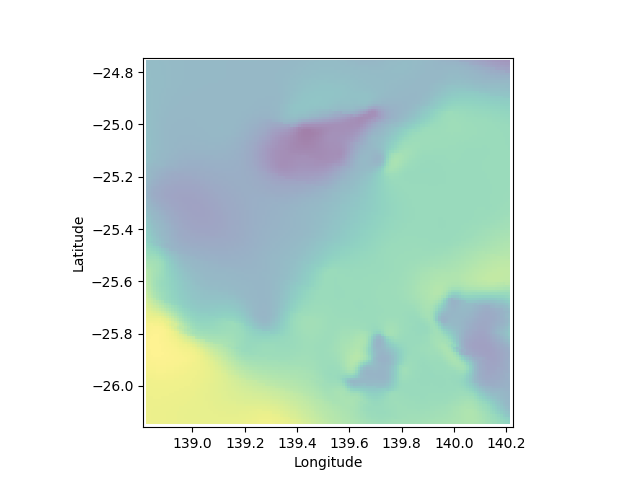

Text(0, 0.5, 'Latitude')

In [270]:
fig1, ax1 = plt.subplots()
show(wt_gab_raster_real_crop1, ax=ax1, cmap=wt_cmap, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [175]:
# Print the array

data_1 = np.copy(data[0,:,:])

filtered_data = np.where(data_1 < 0, np.nan, data_1)

print(type(filtered_data))
print(filtered_data.shape)

<class 'numpy.ndarray'>
(11530, 10825)


Text(0.5, 1.0, 'Real gab wt np array - upscaled')

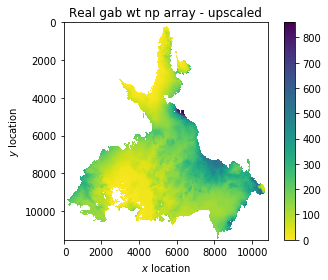

In [180]:
fig, ax = plt.subplots(1)

img = ax.imshow(filtered_data, cmap=wt_cmap)
ax.set_xlabel("$x$ location")
ax.set_ylabel("$y$ location")
ax.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
plt.colorbar(img)


ax.set_title('Real gab wt np array - upscaled')

In [147]:
# make new raster from this data

new_dataset = rasterio.open('test1.tif', 'w', driver='GTiff',
                            height = data.shape[1], width = data.shape[2],
                            count=1, dtype=str(data.dtype),
                            crs='EPSG:4326',
                            transform=transform)
new_dataset.write(data[0,:,:], 1)
new_dataset.close()

print(type(new_dataset))
new_dataset.shape

<class 'rasterio.io.DatasetWriter'>


(11530, 10825)

In [150]:
os.getcwd()

'C:\\Users\\mar886\\WaterTableProject\\aewt_project'

In [151]:
# Now pull this dataset in

wt_rstr_real_file = os.path.join("test1.tif")

wt_gab_raster1_ups = rio.open(wt_rstr_real_file,
                         driverstr="GTiff")

Upscaled raster shape: (11530, 10825)


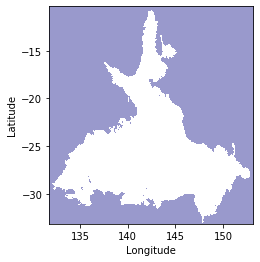

In [152]:
fig1, ax1 = plt.subplots()
show(wt_gab_raster1_ups, ax=ax1, cmap="terrain", alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

print("Upscaled raster shape: %s" %(wt_gab_raster1_ups.shape,))

## Now open the real water table cropped tiff and save it as a np array

**But when compared to the bounding box from my DEM, it can be seen that they are slightly different, not sure what I should do here.**

In [83]:
with rio.open(os.path.join("output_data", "gab_real_crop.tif")) as grd_wt:
    wt_real_crop = grd_wt.read()[0,:,:] # Reads it as a numpy array
    wt_real_crop_meta = grd_wt.profile   # Gets the metadata automatically
    wt_real_crop_bounds = grd_wt.bounds
    wt_real_crop_res = grd_wt.res
    
print(bounds)
print(wt_real_crop_bounds)

print("Shape of the real water table is: %s" %(wt_real_crop.shape,))

BoundingBox(left=138.92013888913038, bottom=-26.049861111151657, right=140.1198611113643, top=-24.849861111139962)
BoundingBox(left=138.9103432122247, bottom=-26.05915118559934, right=140.12623864520972, top=-24.84325575261431)
Shape of the real water table is: (123, 123)


In [105]:
bounds_diff = np.array([bounds[0] - wt_real_crop_bounds[0],
                        bounds[1] - wt_real_crop_bounds[1],
                        bounds[2] - wt_real_crop_bounds[2],
                        bounds[3] - wt_real_crop_bounds[3]])
print(bounds_diff)
type(bounds_diff)

[ 0.00979568  0.00929007 -0.00637753 -0.00660536]


numpy.ndarray

This is in degrees convert to metres --- very very approximate these values are for the equator and from Wikipedia! http://wiki.gis.com/wiki/index.php/Decimal_degrees

In [106]:
degr_conv = 111000 # 1 degre = 111 km

In [108]:
bounds_diff_approx_m = bounds_diff*degr_conv
print(bounds_diff_approx_m)

[1087.32013653 1031.19826369 -707.90625684 -733.19479635]
